In [31]:
import os
import sys
from pathlib import Path

# Dynamically locate project root and set working dir
project_root = Path().
os.chdir(project_root)
sys.path.append(str(project_root))
print(os.getcwd())


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from ydata_profiling import ProfileReport
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

C:\Users\naras


# Table of Contents
- [Data Description](#Data-Description)
    - [Feature Description](#Feature-Description)
    - [Data Profiling](#Data-Profiling)
- [Target and Feature Dependency Analysis](#Target-and-Feature-Dependency-Analysis)
    - [Data Analysis](#Data-Analysis)
    - [Analysis Conclusions](#Analysis-Conclusions)

# Data Description

 - This project aims to obtain realtime predictions of key critical process parameters indicative of final pennicilin yield. Currently, these parameters are being measured in 12 minute intervals, which is leading to suboptimal pennicilin yields, as the optimum time to intervene and conclude a batch depends on measuring the pennicilin concentration in the vessel in realtime.
 - The data for this project has been simulated using a biopharmaceutical simulation software in MATLAB. The link is to be accessed here:

http://www.industrialpenicillinsimulation.com/
 - The corresponding academic research paper, on which this EDA and Modelling is based on, is to be accessed here:

https://doi.org/10.1016/j.compchemeng.2019.05.037


### Raw input and measurements data ###

#### we are reading in the raw simulation data in for EDA purposes.
#### we are only taking in the first 50 columns to avoid crashing out the notebook server.

In [24]:
df = pd.read_csv('./data/raw_data/data_first40columns.csv',
                 usecols=list[np.arange(1,50,1)])
df = df.rename(columns={'2-PAT control(PAT_ref:PAT ref)': 'Batch reference(Batch_ref:Batch ref)','Batch reference(Batch_ref:Batch ref)':'2-PAT control(PAT_ref:PAT ref)'})

df.head(10)

FileNotFoundError: [Errno 2] No such file or directory: './data/raw_data/data_first40columns.csv'

In [8]:
df[df.columns[:40]].isna().sum()

Time (h)                                                                   0
Aeration rate(Fg:L/h)                                                      0
Agitator RPM(RPM:RPM)                                                      0
Sugar feed rate(Fs:L/h)                                                    0
Acid flow rate(Fa:L/h)                                                     0
Base flow rate(Fb:L/h)                                                     0
Heating/cooling water flow rate(Fc:L/h)                                    0
Heating water flow rate(Fh:L/h)                                            0
Water for injection/dilution(Fw:L/h)                                       0
Air head pressure(pressure:bar)                                            0
Dumped broth flow(Fremoved:L/h)                                            0
Substrate concentration(S:g/L)                                             0
Dissolved oxygen concentration(DO2:mg/L)                                   0

 -  The offline PAA, NH3, Pennicillin, Biomass and Viscoscity measurements show a high number of NA values. This is due to the fact that the readings are taken at 12 Hour intervals. A groupy analysis based on the time variable will confirm this.

In [9]:
target_features = ['PAA concentration offline(PAA_offline:PAA (g L^{-1}))','Offline Biomass concentratio(X_offline:X(g L^{-1}))',
                   'Viscosity(Viscosity_offline:centPoise)','Offline Penicillin concentration(P_offline:P(g L^{-1}))',
                  'NH_3 concentration off-line(NH3_offline:NH3 (g L^{-1}))']

input_features = ['carbon dioxide percent in off-gas(CO2outgas:%)','Oxygen in percent in off-gas(O2:O2  (%))',
                  'Dissolved oxygen concentration(DO2:mg/L)','Vessel Weight(Wt:Kg)','pH(pH:pH)','Temperature(T:K)','2400']

 - Here we are separating the variables into target and input variables. We are interested in obtaining real time predictions of the measurements currently being taken only in 12h intervals. For this, we are going to use on-line measurements being recorded in real time
 - The challenge here is that the target variables have values only at the 12th hour. In the modelling section we will approach this with methods to impute missing data, as dropping them alltogether is not an option in this case.

### Grouped version of raw dataframe for better time series visualization and correlation analysis

In [12]:
df_grouped =  pd.DataFrame(df.groupby('Time (h)').mean()) # here we are taking all the attributes until column '2400'.


In [13]:
df_grouped[['PAA concentration offline(PAA_offline:PAA (g L^{-1}))','Offline Biomass concentratio(X_offline:X(g L^{-1}))',
                   'Viscosity(Viscosity_offline:centPoise)','Offline Penicillin concentration(P_offline:P(g L^{-1}))',
           '2400']].corr()


,PAA concentration offline(PAA_offline:PAA (g L^{-1})),Offline Biomass concentratio(X_offline:X(g L^{-1})),Viscosity(Viscosity_offline:centPoise),Offline Penicillin concentration(P_offline:P(g L^{-1})),2400
PAA concentration offline(PAA_offline:PAA (g L^{-1})),1.000000,-0.352293,0.273746,-0.362574,0.072894
Offline Biomass concentratio(X_offline:X(g L^{-1})),-0.352293,1.000000,0.610627,0.796679,0.723897
Viscosity(Viscosity_offline:centPoise),0.273746,0.610627,1.000000,0.636313,0.876262
Offline Penicillin concentration(P_offline:P(g L^{-1})),-0.362574,0.796679,0.636313,1.000000,0.806744
2400,0.072894,0.723897,0.876262,0.806744,1.000000


- from the above table, the raman spectroscopy reading shows high correlation with the several of the target variables, with the highest being the viscoscity.

### correlation analysis of selected features deemed relevant from simulation study

 - #### input features correlation

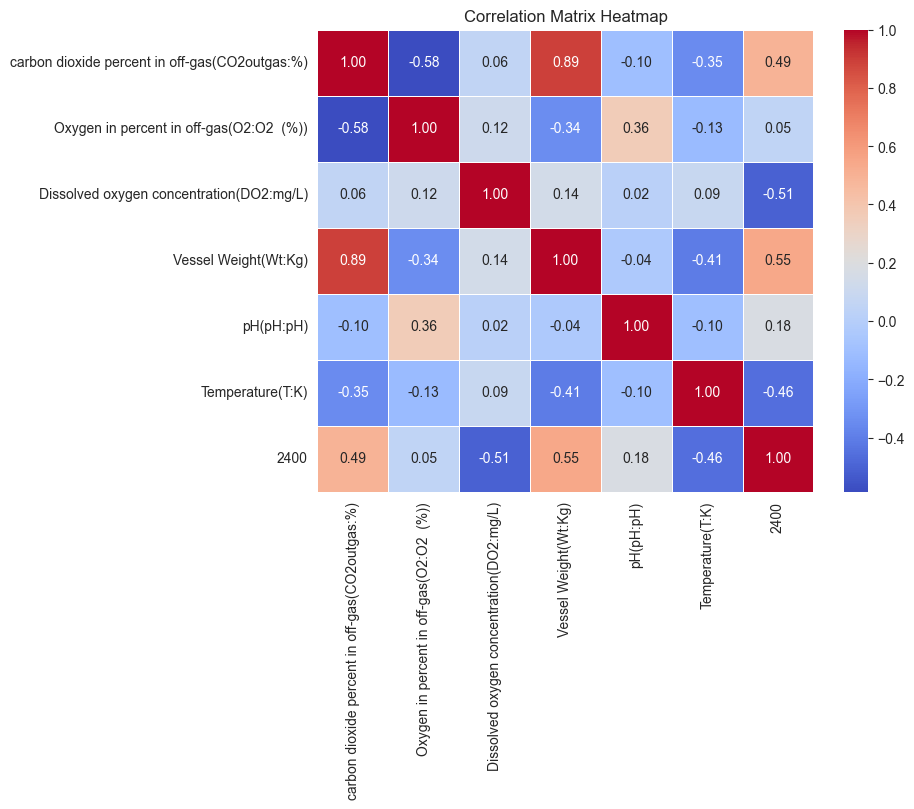

In [14]:


correlation_matrix = df_grouped[input_features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

plt.title('Correlation Matrix Heatmap')
plt.show()

 - #### From the above correlation matrix, we can observe that the offline carbon dioxide measurement is highly correlated with the vessel weight.
 - #### Besides this, the other features do not seem to be correlated with each other to an extent where we would have to remove one of them

 - #### input features with target features correlation 

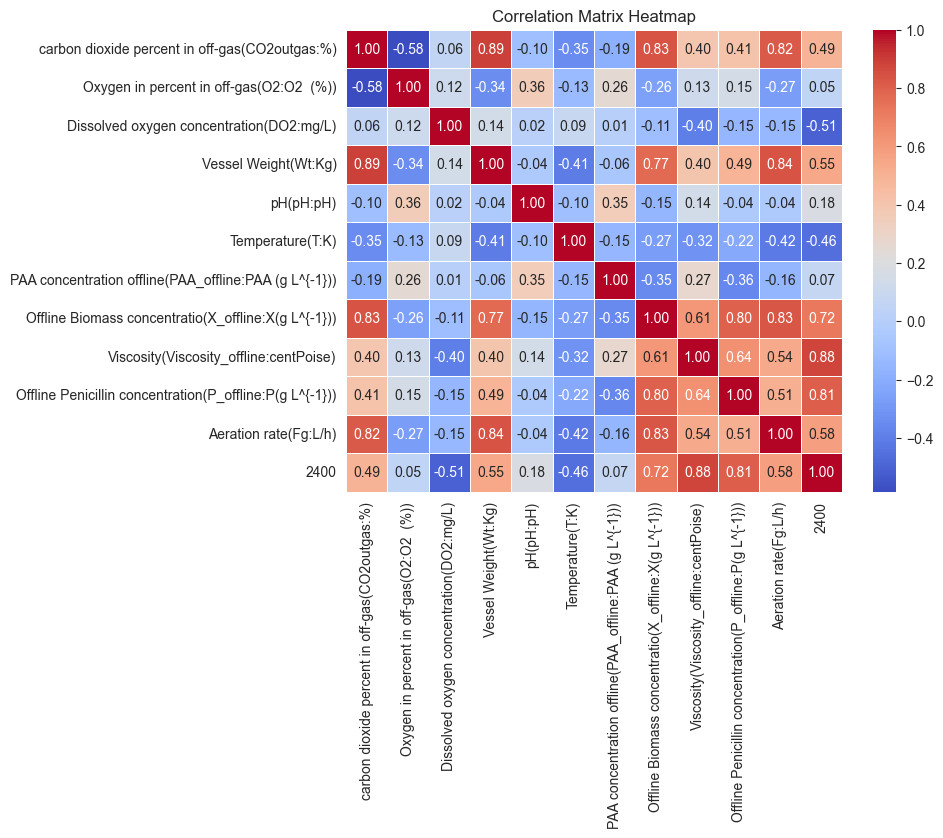

In [15]:
correlation_matrix = df_grouped[['carbon dioxide percent in off-gas(CO2outgas:%)','Oxygen in percent in off-gas(O2:O2  (%))',
                  'Dissolved oxygen concentration(DO2:mg/L)','Vessel Weight(Wt:Kg)','pH(pH:pH)','Temperature(T:K)',
                                'PAA concentration offline(PAA_offline:PAA (g L^{-1}))','Offline Biomass concentratio(X_offline:X(g L^{-1}))',
                   'Viscosity(Viscosity_offline:centPoise)','Offline Penicillin concentration(P_offline:P(g L^{-1}))','Aeration rate(Fg:L/h)',
                                 '2400']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

plt.title('Correlation Matrix Heatmap')
plt.show()

 - #### from a correlation viewpoint, it seems that the raman spectroscopy readings at 2400 mmm is a good predictor of the  target variables in the bottom

 - #### half of the columns in the y axis. Furthermore, the vessel weight seems to impact the offline biomass concentration, which is reasonable,
   #### as increased biomass in the chamber results in a higher vessel weight

### yield data from individual batch runs ###

In [455]:
df_yield = pd.read_csv('./data/raw_data/Mendeley_data/100_Batches_IndPenSim_Statistics.csv')
df_yield.loc[:,:]

,Batch ref,Penicllin_harvested_during_batch(kg),Penicllin_harvested_end_of_batch (kg),Penicllin_yield_total (kg),Fault ref(0-NoFault 1-Fault)
0,1,1066400.0,1720000.0,2786400.0,0
1,2,985910.0,1340100.0,2326000.0,0
2,3,1416100.0,1259200.0,2675300.0,0
3,4,815700.0,1071000.0,1886700.0,0
4,5,1128500.0,2434400.0,3562900.0,0
...,...,...,...,...,...
95,96,1141500.0,2453400.0,3595000.0,1
96,97,1439400.0,2454900.0,3894300.0,1
97,98,799760.0,930830.0,1730600.0,1
98,99,388650.0,502180.0,890830.0,1


 - #### The aim of the accompanying research paper was to investigate the ability of the raman spectroscopy readings being a reliable predictor for offline PAA concentrations, as this variable has been proven to be an indicator of pennicilin yields at the end of a batch run.

 - #### Batch runs 60 to 90 were controlled by the spectroscopy readings, hence we are separating them from the operator, manually controlled batch runs.

In [155]:

# dataframe Controlled by operators
df_operator = df[df['0 - Recipe driven 1 - Operator controlled(Control_ref:Control ref)'] == 1].loc[:,:'2400']


# dataframe Controlled by an Advanced Process Control (APC) solution using the Raman spectroscopy 
df_raman = df[df['1- No Raman spec'] == 2]

## Feature Description

- Time - quarter hourly (quarter hourly increment of time axis for each batch run)

- Manual control features 
  - 'Aeration rate(Fg:L/h)'
  - 'Agitator RPM(RPM:RPM)'
  - 'Sugar feed rate(Fs:L/h)'


- Automatic control features
  - 'Heating/cooling water flow rate(Fc:L/h)'
  - 'Acid flow rate(Fa:L/h)'
  - 'Base flow rate(Fb:L/h)'


- Off line measurements ( measurements taken at the end of a batch run )
  - PAA concentration offline(PAA_offline:PAA (g L^{-1}))
  - 'NH_3 concentration off-line(NH3_offline:NH3 (g L^{-1}))'
  - 'Viscosity(Viscosity_offline:centPoise)'
  - 'Offline Penicillin concentration(P_offline:P(g L^{-1}))'
    



- On line measurements (measurements taken during a batch run )
  - 'Acid flow rate(Fa:L/h)'
  -'Base flow rate(Fb:L/h)'
  - 'Heating/cooling water flow rate(Fc:L/h)'
  -'Heating water flow rate(Fh:L/h)'
  -'Water for injection/dilution(Fw:L/h)'
  -'Air head pressure(pressure:bar)'
  - 'Dumped broth flow(Fremoved:L/h)'
  -'Substrate concentration(S:g/L)'
  -'Dissolved oxygen concentration(DO2:mg/L)'

  


## Data Profiling

In [16]:
df_grouped['Offline Penicillin concentration(P_offline:P(g L^{-1}))'].dropna()

Time (h)
1.0       0.000920
12.0      0.000969
24.0      0.009432
36.0      1.510487
48.0      3.762015
60.0      6.139968
72.0      8.430576
84.0     10.916875
96.0     13.154786
108.0    15.404413
120.0    17.508548
132.0    19.333205
144.0    20.969832
156.0    22.403136
167.0    21.524000
168.0    23.133905
179.0    28.038000
180.0    23.862750
181.0    27.707000
188.0    26.891000
192.0    24.462736
193.0    30.137000
196.0    28.196000
200.0    31.809000
202.0    33.518000
204.0    24.472347
205.0    28.492000
207.0    19.314000
210.0    25.340500
211.0    16.709150
214.0    33.014000
216.0    24.363173
220.0    33.167000
222.0    31.473000
224.0    27.424000
225.0    17.791567
226.0    29.386000
228.0    23.757525
230.0    24.205967
231.0    22.954333
232.0    23.393500
234.0    32.510000
235.0    29.836000
236.0    26.704000
240.0    19.765031
241.0    27.249500
243.0    26.893000
250.0    33.581000
251.0     5.481900
252.0    16.266600
258.0     3.166500
260.0    13.229000
261

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2238/2238 [00:11<00:00, 203.37it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

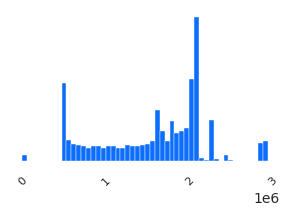

In [161]:
profile = ProfileReport(df_grouped,minimal=True)
profile

## Data Profiling Observations

1. No Missing Values
All 16 fields (season, yr, mnth, holiday, weekday, workingday, weathersit, temp, atemp, hum, windspeed, casual, registered, cnt, plus the datetime index) are 100 % complete—no nulls detected.

2. Strong Right Skew in Rental Counts
The cnt distribution is heavily right‐skewed: most days see moderate rentals, with a long tail of very high-demand days (e.g., special events or heatwaves). This means that for linear models especially this target will be hard to predict, so some transformation might be needed.

3. Registered Riders Dominate
On average, registered users make up ~75 % of all rentals (mean registered ≈ 150 vs. mean casual ≈ 35), and registered correlates with cnt at r ≈ 0.95.

4. Temperature Is a Key to predict the target (cnt)
temp (normalized [°C]) shows a strong positive correlation with cnt (r ≈ 0.4–0.5), peaking around 20–25 °C.

5. Holiday Impact
Rental counts on official holidays drop ~30 % below non‐holiday days, even if they fall on a weekday.

6. Categorical features all have few levels (season=4; yr=2; mnth=12; weekday=7; weathersit=4), making one-hot encoding straightforward if required.

7. As weather gets worse, the number of data samples decreases which makes the weather feature a good predictor.

8. Holiday is an imbalanced feature as expected since there are less days which are holidays.

# Target and Feature Dependency Analysis

## Data Analysis

### Target

Let's visualize the target using Plotly for easy scrolling along the time series

- #### Time series plot of the continously measured pennicilin concentration

In [17]:
# Create figure
fig = go.Figure()


# Add trace
fig.add_trace(go.Scatter(
    x=df_grouped.index,
    y=df_grouped['Penicillin concentration(P:g/L)'],
    mode="lines",  # or "lines+markers"
    name="y value",
   
))

fig.update_layout(
    width=1000,    # width in pixels
    height=400,   # height in pixels
    xaxis_title='Time in 12 Minutes Intervals',
    yaxis_title='Raman Spectra Reading (2400mm wavelength)'

)
fig.show()

Let's check how do the offline measured variables, including the target, varies over the duration over all batch runs

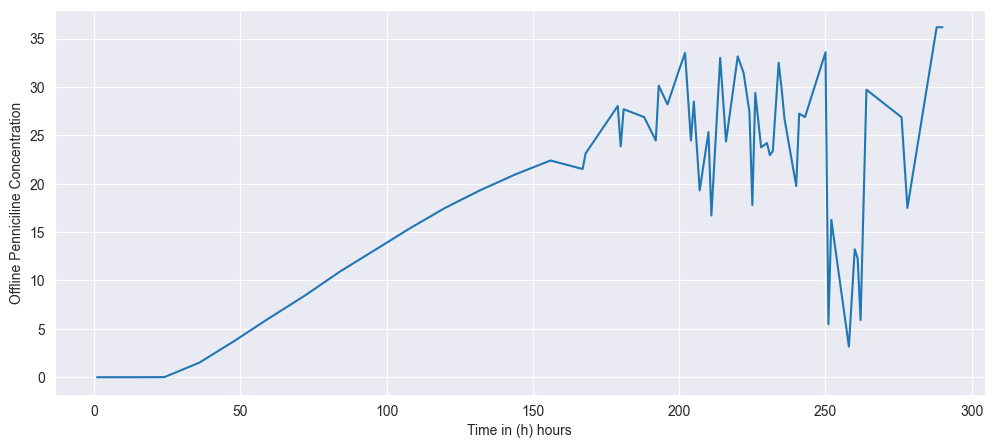

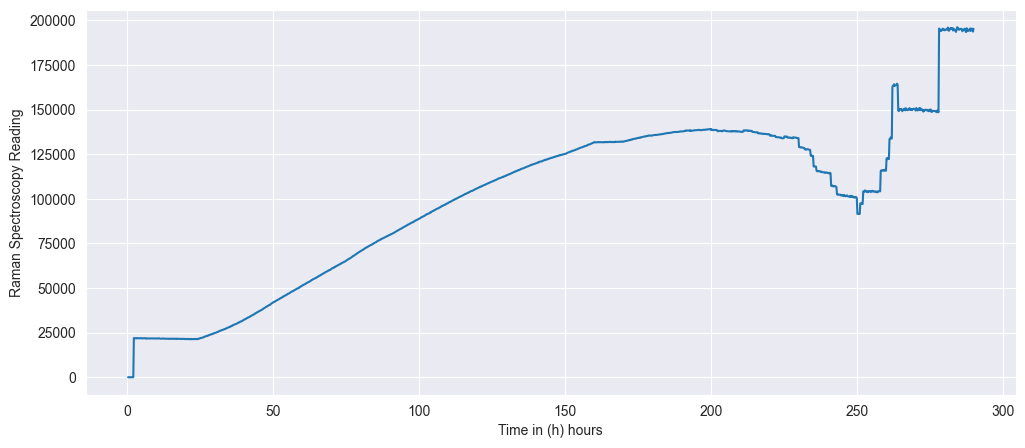

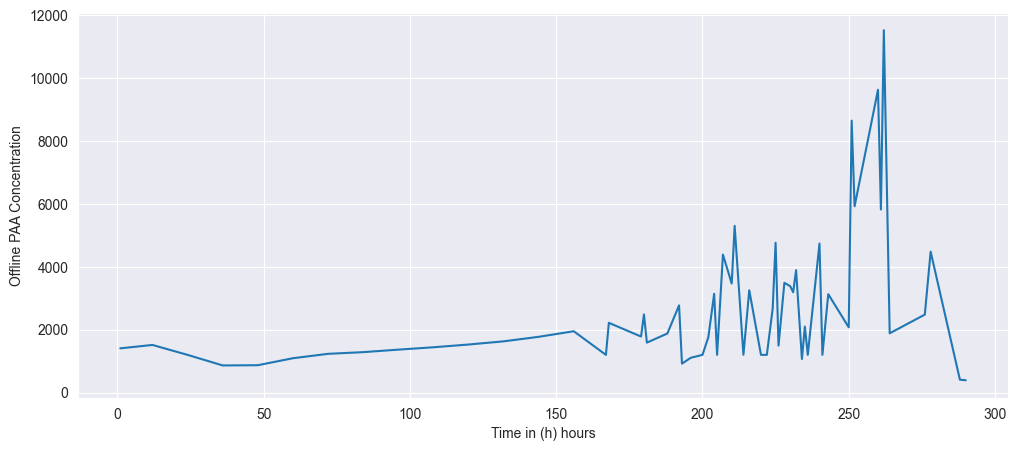

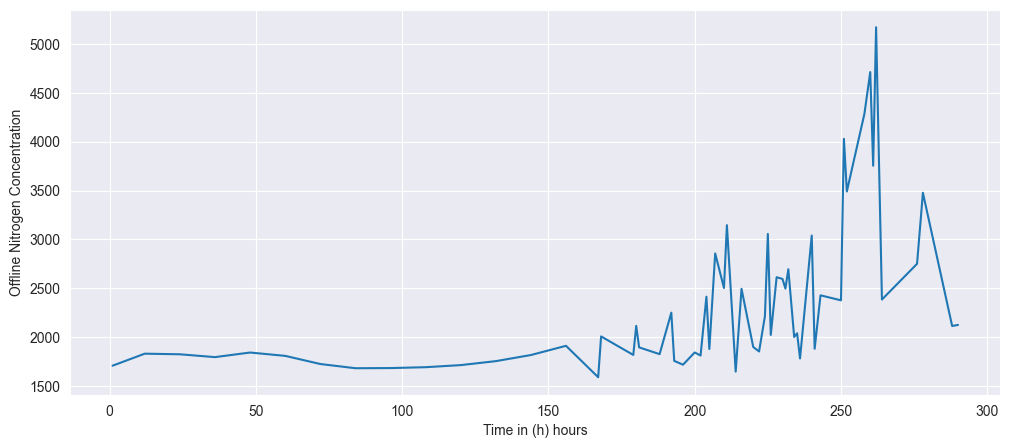

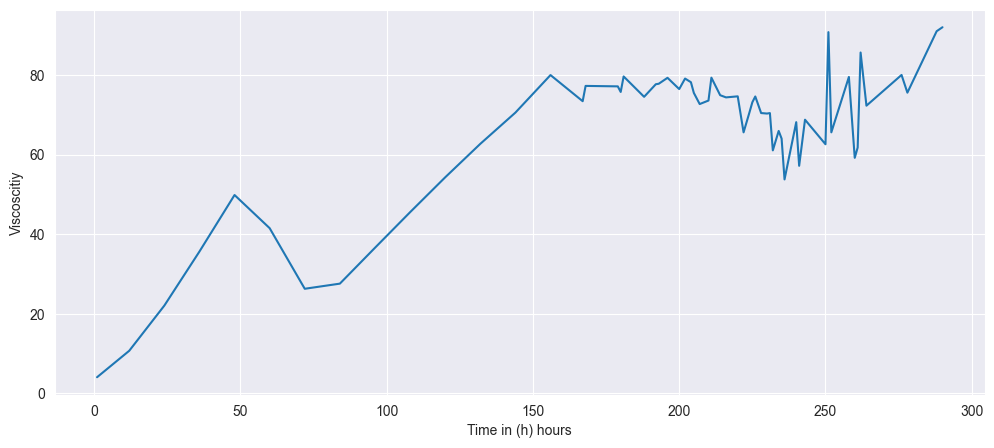

In [18]:
#target_h = df.groupby('hr')['cnt'].mean() # Hourly mean data
target = df_grouped['Offline Penicillin concentration(P_offline:P(g L^{-1}))'].dropna()
raman = df_grouped["2400"]
paa_offline = df_grouped['PAA concentration offline(PAA_offline:PAA (g L^{-1}))'].dropna()
nitrogen_offline = df_grouped['NH_3 concentration off-line(NH3_offline:NH3 (g L^{-1}))'].dropna()
viscoscity = df_grouped['Viscosity(Viscosity_offline:centPoise)'].dropna()

titles = ["Offline Penniciline Concentration","Raman Spectroscopy Reading","Offline PAA Concentration","Offline Nitrogen Concentration","Viscoscitiy"]
cols = [target,raman,paa_offline,nitrogen_offline,viscoscity]
for a,b  in zip(titles,cols) :
    plt.figure(figsize=(12, 5))
    plt.xlabel("Time in (h) hours")
    plt.ylabel(a)
    plt.plot(b)


**Target Observations**
- We can clearly see that the target has a certain peak, after which the pennicilin concentrations drop off or fluctuates strongly. Our aim is to identify the time of the occurence of this peak for a given set of input parameters, to stop the batch run once the maximum concentration has been achieved.
- We can observe that the rest of the offline measured variables, including the spectroscopy readings, display a similiar behaviour, which is a slow climb towards a peak, and erratic/ fluctuating behaviour after this steady climb.
- Potentially, this can be modelled by a time series forecasting model. However, just a normal regression approach can also work because we have relevant features.
 


 *Analysis Conclusions*

**Seasonality Effects**
- Mean rentals are lowest in Winter and highest in Summer and Spring.
- Fall has moderate rentals, suggesting weather strongly impacts usage.

**Weather Conditions**
- Rentals drop sharply as weather worsens.
- Clear weather has the highest rentals.
- Mist or cloudy conditions slightly reduce rentals.
- Light snow/rain causes a large drop.
- Heavy rain/snow leads to very low rentals.

**Weekday Patterns**
- Rentals are relatively uniform across all weekdays, with a slight drop on Sunday.
- Indicates no strong day-of-week effect, possibly due to consistent commuter behavior.

**Holidays vs Non-Holidays**
- Non-holidays have slightly more rentals than holidays.
- Suggests people use bikes more for commuting than for recreation.


**Temperature vs Rentals**
- Positive correlation: Higher temperatures are associated with more rentals.
- Indicates people prefer biking in warmer weather.
- We also see that there are a lot of zero rentals across the entire temperature range. This might be a challenge in terms of building a model

**Humidity vs Rentals**
- Negative trend: As humidity increases, rentals decrease.
- High humidity may discourage outdoor activity.
- Similar to temperature, many rentals are zero across a wide humidity range.

**Windspeed vs Rentals**
- Slight negative correlation: Higher windspeed slightly reduces rentals.
- But the effect is less pronounced than temperature or humidity.
- We also see that windspeed has a clear descrite behavior and overall does not seem to be a good feature for the model.

**Overall Conclusions**
- The target has a strong seasonal behavior, especially daily.
- Strong predictors: temp, season, weather, workingday – clear patterns with rentals.
- Moderate predictors: humidity (weak negative trend), weekday (slight variation).
- Weak predictor: windspeed – little impact on rentals.